Adapted from "2025-05-15 Full tracking optimization of steering for real BBA offsets - new optimizer.ipynb"

Basically just copy-pasted whole chunks but replaced misalignment and steering implementation with applyOtherConfig()

In [1]:
from UTILITY_quickstart import *  
from tabulate import tabulate
import json


importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline2.yml")  

#New DL10 centering 
importedDefaultSettings = importedDefaultSettings | {"centerDL10" : True}

#Disable BC14 centering
importedDefaultSettings = importedDefaultSettings | { "centerBC14" : False }

In [2]:
csrTF           = True #This config is intended for use with CSR on... but for speed, start with it off
transverseWakes = True #Initially disabling for faster computation

evalElement = "Q19501"   
inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"] 
bunchCount = importedDefaultSettings["bunchCount"] 

tao = initializeTao(     
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,          
    csrTF = csrTF,     
    numMacroParticles=1e4,     
    scratchPath = "/tmp",     
    randomizeFileNames = True,      
    transverseWakes = transverseWakes 
)


totalNumElements = len(tao.lat_list("*", "ele.name"))

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Transverse wakes enabled!
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /tmp/beams/activeBeamFile_7633714340745381704.h5, and reinit to tao


In [3]:
# For simplicity, disable all apertures. Very nonphysical, but the single particle tracking failure is causing problems

for eleII in range(totalNumElements):
    try:
        tao.cmd(f"set ele {eleII} APERTURE_AT = NO_APERTURE")
    except:
        pass

In [4]:
trackBeam(tao, 
          trackEnd = "L0BFEND", 
          verbose = True
         ) 
PInit = getBeamAtElement(tao, "L0AFEND")

artificialFactor = 1.3 
#artificialFactor = 1.0 
PInit.x = artificialFactor * PInit.x 
PInit.px = artificialFactor * PInit.px 
PInit.y = artificialFactor * PInit.y 
PInit.py = artificialFactor * PInit.py  

makeBeamActiveBeamFile(PInit, tao = tao)

Loaded /tmp/beams/activeBeamFile_7633714340745381704.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting


In [5]:
# tao.lat_list("Q*", "ele.name", flags="-no_slaves") 
# Manually pared list of only "normal" quads in L1, L2, and L3
linacQuads = [
    'QM10771', 'QM10781', 'QA11132', 'Q11201', 'QA11265', 'Q11301', 
    'QM11393', 'Q11401', 'Q11501', 'Q11601', 'Q11701', 'Q11801', 'Q11901', 'Q12201', 'Q12301', 'Q12401', 'Q12501', 'Q12601', 'Q12701', 'Q12801', 'Q12901', 'Q13201', 'Q13301', 'Q13401', 'Q13501', 'Q13601', 'Q13701', 'Q13801', 'Q13901', 'Q14201', 'Q14301', 'Q14401', 'Q14501', 'Q14601', 'Q14701', 'QM14715',
    'QM14891', 'Q14901', 'Q15201', 'Q15301', 'Q15401', 'Q15501', 'Q15601', 'Q15701', 'Q15801', 'Q15901', 'Q16201', 'Q16301', 'Q16401', 'Q16501', 'Q16601', 'Q16701', 'Q16801', 'Q16901', 'Q17201', 'Q17301', 'Q17401', 'Q17501', 'Q17601', 'Q17701', 'Q17801', 'Q17901', 'Q18201', 'Q18301', 'Q18401', 'Q18501', 'Q18601', 'Q18701', 'Q18801', 'Q18901', 'Q19201', 'Q19301', 'Q19401', 'Q19501', 'Q19601', 'Q19701', 'Q19801', 'Q19851', 'Q19871'
]

#quadsToPerturb = linacQuads

#To accommodate 2014 BBA data, pick subset from z = 1100 to 1800
quadsToPerturb = [
    'Q11801', 'Q11901', 'Q12201', 'Q12301', 'Q12401', 'Q12501', 'Q12601', 'Q12701', 'Q12801', 'Q12901', 'Q13201', 'Q13301', 'Q13401', 'Q13501', 'Q13601', 'Q13701', 'Q13801', 'Q13901', 'Q14201', 'Q14301', 'Q14401', 'Q14501', 'Q14601', 'Q14701', 'QM14715',
    'QM14891', 'Q14901', 'Q15201', 'Q15301', 'Q15401', 'Q15501', 'Q15601', 'Q15701', 'Q15801', 'Q15901', 'Q16201', 'Q16301', 'Q16401', 'Q16501', 'Q16601', 'Q16701', 'Q16801', 'Q16901', 'Q17201', 'Q17301', 'Q17401', 'Q17501', 'Q17601', 'Q17701', 'Q17801', 'Q17901', 'Q18201', 'Q18301', 'Q18401', 'Q18501', 'Q18601', 'Q18701', 'Q18801', 'Q18901', 'Q19201', 'Q19301', 'Q19401', 'Q19501', #'Q19601', 'Q19701'
]

## Baseline

In [6]:
setLattice(tao, **importedDefaultSettings)

trackBeam(tao, 
          trackEnd = evalElement,
          **importedDefaultSettings,
          verbose = True
         )

Loaded /tmp/beams/activeBeamFile_7633714340745381704.h5
Set track_start = L0AFEND, track_end = Q19501
Set track_end = ENDDL10
Tracking!
Beam centered at ENDDL10 written to /tmp/beams/patchBeamFile_7633714340745381704.h5
Loaded /tmp/beams/patchBeamFile_7633714340745381704.h5
Set track_start = ENDDL10, track_end = Q19501
Tracking!
trackBeam() exiting


In [7]:
activeData = {}
for activeEle in  [ "PR10571", "WS12214", "BEGBC14_1", "ENDBC14_2", "Q19501" ]:
    # print(activeEle)
    # print(f"""{getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6:.2f}, {getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6:.2f}""")
    # print()
    activeData[f"{activeEle}_x"] = getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6
    activeData[f"{activeEle}_y"] = getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6

printableData = { key : f"""{activeData[key]:.2f}""" for key in activeData.keys() }

print(tabulate([
    ["PR10571",                  printableData["PR10571_x"], printableData["PR10571_y"]], 
    ["WS12214",                  printableData["WS12214_x"], printableData["WS12214_y"]],
    ["BEGBC14",                  printableData["BEGBC14_1_x"], printableData["BEGBC14_1_y"]],
    ["ENDBC14",                  printableData["ENDBC14_2_x"], printableData["ENDBC14_2_y"]],
    ["Q19501\n(L3 wire proxy)", printableData["Q19501_x"], printableData["Q19501_y"]]
], 
["90% RMS\nemittance (not\nSI90!) [um-rad]", "\n     X     ", "\n     Y     "], 
tablefmt="grid"))

+-------------------+---------------+---------------+
| 90% RMS           |               |               |
| emittance (not    |        X      |        Y      |
| SI90!) [um-rad]   |               |               |
+===================+===============+===============+
| PR10571           |          4.03 |          2.93 |
+-------------------+---------------+---------------+
| WS12214           |          4.62 |          2.79 |
+-------------------+---------------+---------------+
| BEGBC14           |          5.47 |          2.75 |
+-------------------+---------------+---------------+
| ENDBC14           |          6.31 |          2.75 |
+-------------------+---------------+---------------+
| Q19501            |          6.73 |          3.75 |
| (L3 wire proxy)   |               |               |
+-------------------+---------------+---------------+


## Apply errors

In [8]:
# def applyOtherConfig(tao, configArr):
#     """
#     The format for other_configs is an array with rows
#     [ elementName, attributeName, setValue ] 
#     """
    
#     #Prevent recalculation until changes are made
#     tao.cmd("set global lattice_calc_on = F")

#     # try: 
#     #     for row in configArr:
#     #         tao.cmd(f"""set ele {row[0]} {row[1]} = {row[2]}""")

#     # except:
#     #     print("WARNING! At least one assignment has failed!")

    
#     for row in configArr:
#         try: 
#             tao.cmd(f"""set ele {row[0]} {row[1]} = {row[2]}""")
#         except Exception as e:
#             print("An error occurred:", e)

#     #Prevent recalculation until changes are made
#     tao.cmd("set global lattice_calc_on = T")

In [9]:
with open('./other_configs/pinkCurveMisalignments.json', 'r') as f:
    misalignmentConfig = json.load(f)

applyOtherConfig(tao, misalignmentConfig) 

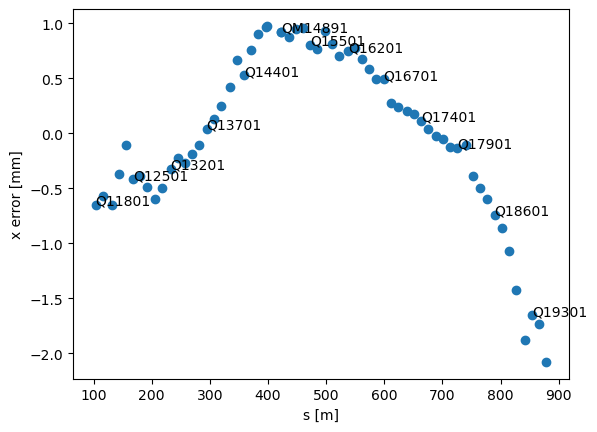

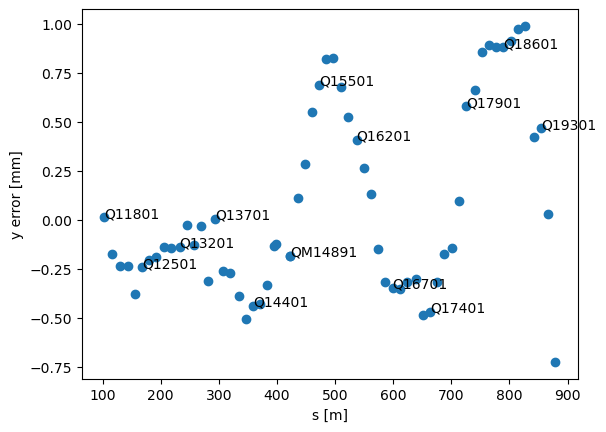

In [11]:
fig, ax = plt.subplots()
ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in quadsToPerturb ],
    [ 1e3 * (tao.ele_floor(ele)["Actual"][0] - tao.ele_floor(ele)["Reference"][0]) for ele in quadsToPerturb]
)

for i, txt in enumerate(quadsToPerturb):
    if i % 5 == 0:
        ax.annotate(txt, ([ tao.ele_head(ele)["s"] for ele in quadsToPerturb ][i], [ 1e3 * (tao.ele_floor(ele)["Actual"][0] - tao.ele_floor(ele)["Reference"][0]) for ele in quadsToPerturb][i]))

ax.set_xlabel("s [m]")
ax.set_ylabel("x error [mm]")

plt.show()


fig, ax = plt.subplots()
ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in quadsToPerturb ],
    [ 1e3 * (tao.ele_floor(ele)["Actual"][1] - tao.ele_floor(ele)["Reference"][1]) for ele in quadsToPerturb]
)

for i, txt in enumerate(quadsToPerturb):
    if i % 5 == 0:
        ax.annotate(txt, ([ tao.ele_head(ele)["s"] for ele in quadsToPerturb ][i], [ 1e3 * (tao.ele_floor(ele)["Actual"][1] - tao.ele_floor(ele)["Reference"][1]) for ele in quadsToPerturb][i]))

ax.set_xlabel("s [m]")
ax.set_ylabel("y error [mm]")

plt.show()

In [12]:
setLattice(tao, **importedDefaultSettings)

trackBeam(tao, 
          trackEnd = evalElement,
          **importedDefaultSettings,
          verbose = True
         )

Loaded /tmp/beams/activeBeamFile_7633714340745381704.h5
Set track_start = L0AFEND, track_end = Q19501
Set track_end = ENDDL10
Tracking!
Beam centered at ENDDL10 written to /tmp/beams/patchBeamFile_7633714340745381704.h5
Loaded /tmp/beams/patchBeamFile_7633714340745381704.h5
Set track_start = ENDDL10, track_end = Q19501
Tracking!
trackBeam() exiting


In [13]:
activeData = {}
for activeEle in  [ "PR10571", "WS12214", "BEGBC14_1", "ENDBC14_2", "Q19501" ]:
    # print(activeEle)
    # print(f"""{getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6:.2f}, {getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6:.2f}""")
    # print()
    activeData[f"{activeEle}_x"] = getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6
    activeData[f"{activeEle}_y"] = getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6
    activeData[f"{activeEle}_charge"] = getBeamAtElement(tao, activeEle).charge * 1e9

printableData = { key : f"""{activeData[key]:.2f}""" for key in activeData.keys() }

In [14]:
# print(tabulate([
#     ["PR10571",                  printableData["PR10571_x"],    printableData["PR10571_y"]  , printableData["PR10571_charge"]   ], 
#     ["WS12214",                  printableData["WS12214_x"],    printableData["WS12214_y"]  , printableData["WS12214_charge"]   ],
#     ["BEGBC14",                  printableData["BEGBC14_1_x"],  printableData["BEGBC14_1_y"], printableData["BEGBC14_1_charge"] ],
#     ["ENDBC14",                  printableData["ENDBC14_2_x"],  printableData["ENDBC14_2_y"], printableData["ENDBC14_2_charge"] ],
#     ["Q19501\n(L3 wire proxy)",  printableData["Q19501_x"],    printableData["Q19501_y"]  , printableData["Q19501_charge"]   ]
# ], 
# ["90% RMS\nemittance (not\nSI90!) [um-rad]", "\n     X     ", "\n     Y     ", "\n  Charge  "], 
# tablefmt="grid"))

print(tabulate([
    ["PR10571",                  printableData["PR10571_x"], printableData["PR10571_y"]], 
    ["WS12214",                  printableData["WS12214_x"], printableData["WS12214_y"]],
    ["BEGBC14",                  printableData["BEGBC14_1_x"], printableData["BEGBC14_1_y"]],
    ["ENDBC14",                  printableData["ENDBC14_2_x"], printableData["ENDBC14_2_y"]],
    ["Q19501\n(L3 wire proxy)",  printableData["Q19501_x"], printableData["Q19501_y"]]
], 
["90% RMS\nemittance (not\nSI90!) [um-rad]", "\n     X     ", "\n     Y     "], 
tablefmt="grid"))

+-------------------+---------------+---------------+
| 90% RMS           |               |               |
| emittance (not    |        X      |        Y      |
| SI90!) [um-rad]   |               |               |
+===================+===============+===============+
| PR10571           |          4.02 |          2.93 |
+-------------------+---------------+---------------+
| WS12214           |          8.41 |          2.9  |
+-------------------+---------------+---------------+
| BEGBC14           |         16.44 |          6.25 |
+-------------------+---------------+---------------+
| ENDBC14           |         12.62 |          6.44 |
+-------------------+---------------+---------------+
| Q19501            |         17.39 |          8.64 |
| (L3 wire proxy)   |               |               |
+-------------------+---------------+---------------+


In [ ]:
from scipy.optimize import minimize



combinedElementData = [
    {
        "eleII" : eleII,
        "name" : tao.ele_head(eleII)["name"],
        "key" : tao.ele_head(eleII)["key"],
        "s" : tao.ele_head(eleII)["s"]
    }
    for eleII in range(totalNumElements) 
]

#Keep only elements after L0AFEND
combinedElementData = [ele for ele in combinedElementData if ele["s"] > 4.1274477]

allHKickerNames = [ele["name"] for ele in combinedElementData if ele["key"] == "HKicker"]
allVKickerNames = [ele["name"] for ele in combinedElementData if ele["key"] == "VKicker"]

#Manually picking a list of elements that seem like BPMs. Fast and dirty, DNT
#[ele["name"] for ele in combinedElementData if ele["key"] == "Monitor"]
#allBPMNames = ['BPM10371', 'BPM10425', 'BPM10511', 'BPM10525',  'BPM10581', 'BPM10631', 'BPM10651', 'BPM10731', 'BPM10771', 'BPM10781', 'BPM11132', 'BPM11201', 'BPM11265', 'BPM11301', 'BPM11312', 'BPM11333', 'BPM11358', 'BPM11362', 'BPM11393', 'BPM11401', 'BPM11501', 'BPM11601', 'BPM11701', 'BPM11801', 'BPM11901', 'BPM12201', 'BPM12301', 'BPM12401', 'BPM12501', 'BPM12601', 'BPM12701', 'BPM12801', 'BPM12901', 'BPM13201', 'BPM13301', 'BPM13401', 'BPM13501', 'BPM13601', 'BPM13701', 'BPM13801', 'BPM13901', 'BPM14201', 'BPM14301', 'BPM14401', 'BPM14501', 'BPM14601', 'BPM14701', 'BPM14715', 'BPM14801', 'BPM14891', 'BPM14901', 'BPM15201', 'BPM15301', 'BPM15401', 'BPM15501', 'BPM15601', 'BPM15701', 'BPM15801', 'BPM15901', 'BPM16201', 'BPM16301', 'BPM16401', 'BPM16501', 'BPM16601', 'BPM16701', 'BPM16801', 'BPM16901', 'BPM17201', 'BPM17301', 'BPM17401', 'BPM17501', 'BPM17601', 'BPM17701', 'BPM17801', 'BPM17901', 'BPM18201', 'BPM18301', 'BPM18401', 'BPM18501', 'BPM18601', 'BPM18701', 'BPM18801', 'BPM18901', 'BL18900', 'BPM19201', 'BPM19301', 'BPM19401', 'BPM19801', 'BPM19851', 'BPM19871', 'M1E', 'M3E', 'MS2EL', 'M4E', 'M5E', 'M6E', 'M7E', 'M8E', 'MS2ER', 'M9E', 'M11E', 'M1FF', 'M2FF', 'M3FF', 'M4FF', 'M5FF', 'M0EX', 'M1EX', 'M2EX', 'M3EX']

#For this notebook only, steer to centers of quads instead of BPMs
#BEWARE!!! Horrible misnomer!!!
allBPMNames = quadsToPerturb




######################################
#Optional: Limit kickers and BPMs by s
######################################

optimizerBPMSMin =  100  #100
optimizerBPMSMax =  880  #905
optimizerKickerSMin = optimizerBPMSMin - 20 #Go a bit upstream from first BPM considered
optimizerKickerSMax = optimizerBPMSMax


allBPMNames     = [ ele for ele in allBPMNames     if optimizerBPMSMin    < tao.ele_head(ele)["s"] < optimizerBPMSMax   ]
allHKickerNames = [ ele for ele in allHKickerNames if optimizerKickerSMin < tao.ele_head(ele)["s"] < optimizerKickerSMax]
allVKickerNames = [ ele for ele in allVKickerNames if optimizerKickerSMin < tao.ele_head(ele)["s"] < optimizerKickerSMax]

#Make sure tracked beam is available at all BPMs
#Doing this in a loop because Bmad sometimes gets weird about long lists...
for ele in allBPMNames:
    tao.cmd(f"set beam add_saved_at = {ele}")

In [18]:
from scipy.optimize import minimize
from scipy.optimize import lsq_linear

def getActualXOffset(tao, ele):
    return tao.ele_orbit(ele)["x"] - (tao.ele_floor(ele)["Actual"][0] - tao.ele_floor(ele)["Reference"][0])

def getActualYOffset(tao, ele):
    return tao.ele_orbit(ele)["y"] - (tao.ele_floor(ele)["Actual"][1] - tao.ele_floor(ele)["Reference"][1])


def makeXPerturbationMatrix(delta, trackEnd = "end"):

    referenceRow = np.array( [ getActualXOffset( tao, ele ) for ele in allBPMNames ] )

    #print(referenceRow) 
    
    perturbationMatrix = []
    
    for kicker in allHKickerNames:

        #Tweak the kicker
        setKickerkG( tao, kicker, delta + getKickerkG( tao, kicker ) )

        trackBeam(tao, 
          trackEnd = trackEnd,
          **importedDefaultSettings
         )

        perturbationRow = np.array( [ getActualXOffset( tao, ele ) for ele in allBPMNames ] ) - referenceRow

        perturbationMatrix.append(perturbationRow) 

        #Put it back where it started
        setKickerkG( tao, kicker, -1 * delta + getKickerkG( tao, kicker ) )

    #Normalize
    perturbationMatrix = np.array(perturbationMatrix) / delta
    
    return perturbationMatrix

def makeYPerturbationMatrix(delta, trackEnd = "end"):

    referenceRow = np.array( [ getActualYOffset( tao, ele ) for ele in allBPMNames ] )

    #print(referenceRow) 
    
    perturbationMatrix = []
    
    for kicker in allVKickerNames:

        #Tweak the kicker
        setKickerkG( tao, kicker, delta + getKickerkG( tao, kicker ) )

        trackBeam(tao, 
          trackEnd = trackEnd,
          **importedDefaultSettings
         )

        perturbationRow = np.array( [ getActualYOffset( tao, ele ) for ele in allBPMNames ] ) - referenceRow

        perturbationMatrix.append(perturbationRow) 

        #Put it back where it started
        setKickerkG( tao, kicker, -1 * delta + getKickerkG( tao, kicker ) )

    #Normalize
    perturbationMatrix = np.array(perturbationMatrix) / delta
    
    return perturbationMatrix


def solveForKickerCorrectionsBounded(perturbationMatrix, referenceRow, bound=0.1):
    P = np.array(perturbationMatrix).T  # [numBPMs x numKickers]
    r = np.array(referenceRow)

    # Solve P @ k = -r using least squares in case it's over/under-constrained
    result = lsq_linear(P, -r, bounds=(-bound, bound))

    if not result.success:
        print("Warning: Solver did not converge.")
    
    return result.x

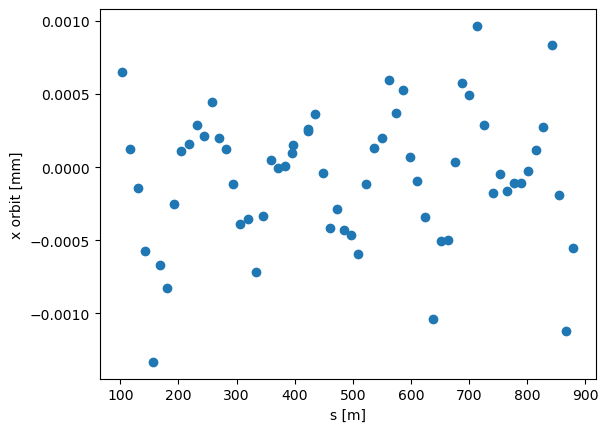

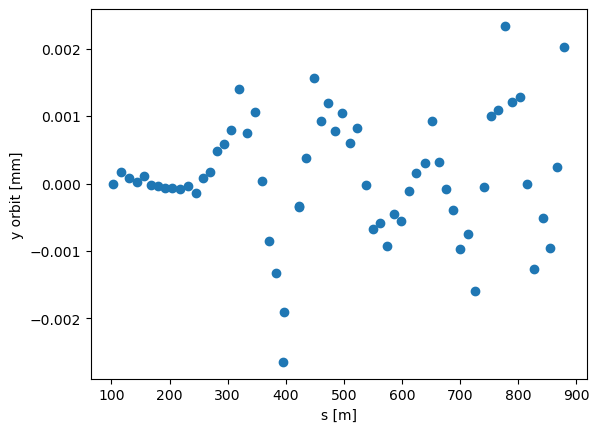

In [19]:
fig, ax = plt.subplots()

ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in allBPMNames ],
    [getActualXOffset(tao,ele) for ele in allBPMNames]
)


ax.set_xlabel("s [m]")
ax.set_ylabel("x orbit [mm]")
plt.show()


fig, ax = plt.subplots()
ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in allBPMNames ],
    [getActualYOffset(tao,ele) for ele in allBPMNames]
)


ax.set_xlabel("s [m]")
ax.set_ylabel("y orbit [mm]")
plt.show()

## Apply steering

In [20]:
with open('./other_configs/2025-06-12_pinkCurveSteering.json', 'r') as f:
    steeringConfig = json.load(f)

applyOtherConfig(tao, steeringConfig) 

In [21]:
trackBeam(tao, 
          trackEnd = evalElement,
          **importedDefaultSettings,
          verbose = True
         )

Loaded /tmp/beams/activeBeamFile_7633714340745381704.h5
Set track_start = L0AFEND, track_end = Q19501
Set track_end = ENDDL10
Tracking!
Beam centered at ENDDL10 written to /tmp/beams/patchBeamFile_7633714340745381704.h5
Loaded /tmp/beams/patchBeamFile_7633714340745381704.h5
Set track_start = ENDDL10, track_end = Q19501
Tracking!
trackBeam() exiting


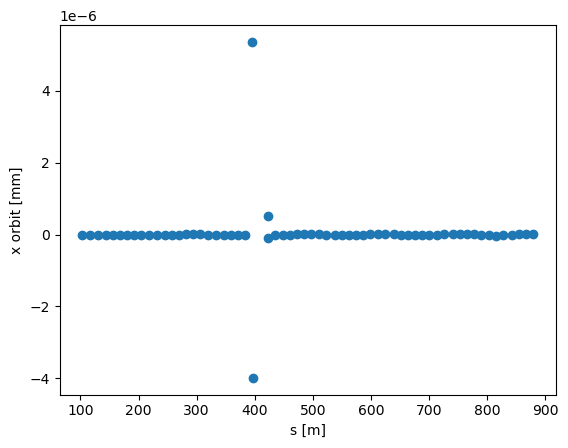

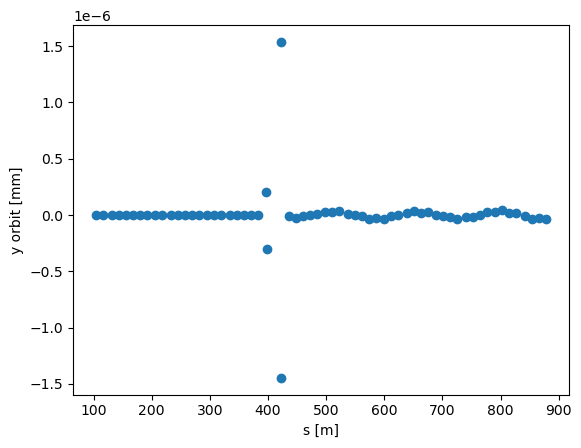

In [22]:
fig, ax = plt.subplots()

ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in allBPMNames ],
    [getActualXOffset(tao,ele) for ele in allBPMNames]
)


ax.set_xlabel("s [m]")
ax.set_ylabel("x orbit [mm]")
plt.show()


fig, ax = plt.subplots()
ax.scatter(
    [ tao.ele_head(ele)["s"] for ele in allBPMNames ],
    [getActualYOffset(tao,ele) for ele in allBPMNames]
)


ax.set_xlabel("s [m]")
ax.set_ylabel("y orbit [mm]")
plt.show()

In [23]:
activeData = {}
for activeEle in  [ "PR10571", "WS12214", "BEGBC14_1", "ENDBC14_2", "Q19501" ]:
    # print(activeEle)
    # print(f"""{getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6:.2f}, {getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6:.2f}""")
    # print()
    activeData[f"{activeEle}_x"] = getBeamAtElement(tao, activeEle).twiss(plane = "x", fraction = 0.9)["norm_emit_x"] * 1e6
    activeData[f"{activeEle}_y"] = getBeamAtElement(tao, activeEle).twiss(plane = "y", fraction = 0.9)["norm_emit_y"] * 1e6

printableData = { key : f"""{activeData[key]:.2f}""" for key in activeData.keys() }

print(tabulate([
    ["PR10571",                  printableData["PR10571_x"], printableData["PR10571_y"]], 
    ["WS12214",                  printableData["WS12214_x"], printableData["WS12214_y"]],
    ["BEGBC14",                  printableData["BEGBC14_1_x"], printableData["BEGBC14_1_y"]],
    ["ENDBC14",                  printableData["ENDBC14_2_x"], printableData["ENDBC14_2_y"]],
    ["Q19501\n(L3 wire proxy)",  printableData["Q19501_x"], printableData["Q19501_y"]]
], 
["90% RMS\nemittance (not\nSI90!) [um-rad]", "\n     X     ", "\n     Y     "], 
tablefmt="grid"))

+-------------------+---------------+---------------+
| 90% RMS           |               |               |
| emittance (not    |        X      |        Y      |
| SI90!) [um-rad]   |               |               |
+===================+===============+===============+
| PR10571           |          4.02 |          2.93 |
+-------------------+---------------+---------------+
| WS12214           |          6.46 |          3.26 |
+-------------------+---------------+---------------+
| BEGBC14           |          9.3  |          5.08 |
+-------------------+---------------+---------------+
| ENDBC14           |         12.59 |          4.31 |
+-------------------+---------------+---------------+
| Q19501            |         15.35 |          6.17 |
| (L3 wire proxy)   |               |               |
+-------------------+---------------+---------------+
